Author: Haotian Tan  
Final Checked by Oct. 8th, 2025

# SHAP analysis

In [6]:
import pandas as pd

df = pd.read_csv(r"merged_all_models_nopersona.csv")

df["Cost"] = df["amount_of_cost"]
df["Unfairness"] = 30 - 2*df["amount_of_allocation"]
df["Emotional Valence"] = df["AA_valence"]
df["Emotional Arousal"] = df["AA_arousal"]


In [7]:
import pandas as pd
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split

features = ["Cost", "Unfairness", "Emotional Valence", "Emotional Arousal"]
NormSHAP_results = []  

for g, g_df in df.groupby("group"):
    X = g_df[features]  
    y = g_df["choice"]

    # Spilt the data by 7:2:1 for train, validation and test   
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=2025
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42025
    )

    split = pd.Series(index=g_df.index, dtype="object")
    split.loc[X_train.index] = "train"
    split.loc[X_val.index] = "val"
    split.loc[X_test.index] = "test"

    # trian the XGBClassifier
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=200,
        max_depth=3,
        learning_rate=0.15,
        subsample=0.5,
        colsample_bytree=0.5,
        eval_metric="logloss",
        random_state=2025
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Model prediction 
    pred_prob = model.predict_proba(X)[:, 1]
    pred_choice = (pred_prob >= 0.5).astype(int)

    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X).values


    shap_df = pd.DataFrame(
        shap_values, columns=[f"SHAP_{c}" for c in features], index=g_df.index
    )

    # Normalized SHAP
    shap_abs_sum = shap_df.abs().sum(axis=1) 
    norm_shap_df = shap_df.div(shap_abs_sum, axis=0)  
    norm_shap_df.columns = [f"NormSHAP_{c}" for c in features]

    # output
    g_result = pd.concat(
        [
            g_df[["id", "trial", "group"]].reset_index(drop=True),  
            g_df[features].reset_index(drop=True),                  
            shap_df.reset_index(drop=True),                       
            norm_shap_df.reset_index(drop=True),               
            g_df[["choice"]].reset_index(drop=True),                
            pd.DataFrame({"pred_prob": pred_prob, "pred_choice": pred_choice}),
            split.reset_index(drop=True).rename("split")            
        ],
        axis=1
    )
    NormSHAP_results.append(g_result)

NormSHAP_results = pd.concat(NormSHAP_results, ignore_index=True)
NormSHAP_results.to_csv("shap_results.csv", index=False)

## Results of model perfomance and SHAP

In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

# get model performance in test dataset
df = pd.read_csv("shap_results.csv")

results_list = []

for (split, g), g_df in df.groupby(["split", "group"]):
    y_true = g_df["choice"]
    y_pred = g_df["pred_choice"]
    y_prob = g_df["pred_prob"]

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    results_list.append({
        "split": split,
        "group": g,
        "accuracy": acc,
        "auc": auc
    })

metrics_df = pd.DataFrame(results_list)
metrics_df.to_csv("xgb_oos_performance.csv", index=False)

for split, split_df in metrics_df.groupby("split"):
    print(f"=== {split.upper()} ===")
    print(split_df.round(4).to_string(index=False))
    print()


=== TEST ===
split       group  accuracy    auc
 test DeepSeek-R1    0.9736 0.9871
 test DeepSeek-V3    0.9971 0.9987
 test     GPT-3.5    0.9167 0.9157
 test     o3-mini    0.9559 0.9876

=== TRAIN ===
split       group  accuracy    auc
train DeepSeek-R1    0.9753 0.9887
train DeepSeek-V3    0.9972 0.9990
train     GPT-3.5    0.9158 0.9109
train     o3-mini    0.9532 0.9875

=== VAL ===
split       group  accuracy    auc
  val DeepSeek-R1    0.9726 0.9843
  val DeepSeek-V3    0.9975 0.9991
  val     GPT-3.5    0.9138 0.9146
  val     o3-mini    0.9551 0.9878



supplementary table 6.3.1, left part

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

np.random.seed(2025)

# Get 95%CI of model performce
# Note that model performance is calculated using the test data, while SHAP values are computed using all the data.

df = pd.read_csv("shap_results.csv")
test_df = df[df["split"] == "test"]

groups_order = ["GPT-3.5", "o3-mini", "DeepSeek-V3", "DeepSeek-R1"]
feature_cols = ["Cost", "Unfairness", "Emotional Valence", "Emotional Arousal"]
shap_cols = ["NormSHAP_" + f for f in feature_cols]

# The bootstrap procedure will take approximately 3 minutes to complete.
n_bootstrap = 10000


# model performance of ACC with bootsrtap CI
mean_accs, lower_ci_acc, upper_ci_acc = [], [], []

for g in groups_order:
    g_df = test_df[test_df["group"] == g].copy()
    g_df['correct'] = g_df['choice'] == g_df['pred_choice']
    id_accs = g_df.groupby('id')['correct'].mean().values
    n = len(id_accs)

    samples_idx = np.random.randint(0, n, size=(n_bootstrap, n))
    boot_means = id_accs[samples_idx].mean(axis=1)

    mean_val = boot_means.mean()
    ci_lower = np.percentile(boot_means, 2.5)
    ci_upper = np.percentile(boot_means, 97.5)

    mean_accs.append(mean_val)
    lower_ci_acc.append(ci_lower)
    upper_ci_acc.append(ci_upper)


# model performance of ROC with bootsrtap CI
fpr_grid = np.linspace(0,1,100)
roc_results = {}
for g in groups_order:
    g_df = test_df[test_df["group"] == g]
    y_true = g_df["choice"].values
    y_prob = g_df["pred_prob"].values
    n = len(y_true)

    tprs, aucs = [], []

    for i in range(n_bootstrap):
        idx = np.random.randint(0, n, size=n)
        y_true_bs = y_true[idx]
        y_prob_bs = y_prob[idx]

        fpr, tpr, _ = roc_curve(y_true_bs, y_prob_bs)
        auc = roc_auc_score(y_true_bs, y_prob_bs)
        tpr_interp = np.interp(fpr_grid, fpr, tpr)

        tprs.append(tpr_interp)
        aucs.append(auc)

    tprs = np.array(tprs)
    mean_tpr = tprs.mean(axis=0)
    lower_tpr = np.percentile(tprs, 2.5, axis=0)
    upper_tpr = np.percentile(tprs, 97.5, axis=0)
    auc_mean = np.mean(aucs)
    auc_ci = (np.percentile(aucs, 97.5) - np.percentile(aucs, 2.5)) / 2
    auc_ci_upper = np.percentile(aucs, 97.5)
    auc_ci_lower = np.percentile(aucs,2.5)
    
    roc_results[g] = (mean_tpr, lower_tpr, upper_tpr, auc_mean, auc_ci, auc_ci_upper, auc_ci_lower)

# Cummulative |Normalized SHAP|

shap_means = {col:[] for col in shap_cols}
shap_sds = {col:[] for col in shap_cols}

# 'lowers' and 'uppers' represent the 95% CI, calculated from the standard error (SE)
#shap_lowers = {col:[] for col in shap_cols}
#shap_uppers = {col:[] for col in shap_cols}

for g in groups_order:
    g_df = df[df["group"] == g].copy()
    g_df[shap_cols] = g_df[shap_cols].abs()
# The standard deviation (s.d.) is calculated across all trials. 
# To compute s.d. at the subject level instead, uncomment the code below.
# Note that this will generally result in smaller s.d. values.
#    g_df = g_df.groupby("id")[shap_cols].mean()
    
    for col in shap_cols:
        mean_val = g_df[col].mean()
        sd_val = g_df[col].std(ddof=1)
        shap_means[col].append(mean_val)
        shap_sds[col].append(sd_val)

#       se_val = id_shap[col].std(ddof=1)/np.sqrt(len(id_shap))
#       shap_lowers[col].append(mean_val - 1.96*sd_val)
#       shap_uppers[col].append(mean_val + 1.96*sd_val)

print("=== ACC with 95% CI ===")
for g, mean_val, low, up in zip(groups_order, mean_accs, lower_ci_acc, upper_ci_acc):
    print(f"{g}: bootstrap mean={mean_val:.4f}, 95% CI=({low:.4f}, {up:.4f})")

print("\n=== ROC with 95% CI ===")
for g in groups_order:
    mean_tpr, lower_tpr, upper_tpr, auc_mean, auc_ci, auc_ci_upper, auc_ci_lower = roc_results[g]
    print(f"{g}: AUC={auc_mean:.4f} , 95% CI=({auc_ci_lower:.4f}, {auc_ci_upper:.4f})")
    print(f"bootstrap mean_tpr: {mean_tpr[:5]} ...")  
    print(f"lower_tpr: {lower_tpr[:5]} ...")
    print(f"upper_tpr: {upper_tpr[:5]} ...\n")

print("\n=== |Normalized SHAP| with sd ===")
for col in shap_cols:
    print(f"{col}:")
    for g, mean_val, sd in zip(groups_order, shap_means[col], shap_sds[col]):
        print(f"  {g}: mean={mean_val:.4f}, sd ={sd:.4f}")

=== ACC with 95% CI ===
GPT-3.5: bootstrap mean=0.9167, 95% CI=(0.9117, 0.9218)
o3-mini: bootstrap mean=0.9555, 95% CI=(0.9518, 0.9592)
DeepSeek-V3: bootstrap mean=0.9972, 95% CI=(0.9961, 0.9981)
DeepSeek-R1: bootstrap mean=0.9732, 95% CI=(0.9701, 0.9762)

=== ROC with 95% CI ===
GPT-3.5: AUC=0.9158 , 95% CI=(0.9084, 0.9230)
bootstrap mean_tpr: [0.04522347 0.32967647 0.40939348 0.4801311  0.53159282] ...
lower_tpr: [0.00992156 0.29084397 0.35579582 0.43270576 0.48027552] ...
upper_tpr: [0.14411152 0.3641288  0.46744058 0.52723224 0.57990812] ...

o3-mini: AUC=0.9877 , 95% CI=(0.9861, 0.9892)
bootstrap mean_tpr: [0.59726891 0.76686348 0.83358238 0.86842385 0.89709804] ...
lower_tpr: [0.57993628 0.74540559 0.81033457 0.85007145 0.87980451] ...
upper_tpr: [0.64256064 0.80345689 0.85536193 0.88918571 0.91525142] ...

DeepSeek-V3: AUC=0.9987 , 95% CI=(0.9979, 0.9993)
bootstrap mean_tpr: [0.64845707 0.97334319 0.99976971 1.         1.        ] ...
lower_tpr: [0.61516494 0.93018207 0.99663819

## Figure of model performance and SHAP

supplementary figure 6.3.1 a-c

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

groups_order = ["GPT-3.5", "o3-mini", "DeepSeek-V3", "DeepSeek-R1"]
n_group = len(groups_order)
#colors = ["#C95A5A", "#A6DAB6", "#28794C", "#8BBAE0", "#4474AF"]
colors = plt.cm.tab10.colors[1:n_group+1]  

n_shap = len(shap_cols)
shap_colors = ["#2171b5", "#6baed6",  "#f26c6c", "#EB1818", ]

fig, axes = plt.subplots(1,3,figsize=(22,6))

font_main = 18  
font_legend = 12  
labelsize = 14 

# Figure of ACC with 95% CI
ax1 = axes[0]
ax1.bar(groups_order, mean_accs,
        yerr=[np.array(mean_accs)-np.array(lower_ci_acc), np.array(upper_ci_acc)-np.array(mean_accs)],
        color=colors, alpha=0.7, capsize=5)
ax1.set_ylabel("Accuracy with 95% CI", fontsize=font_main)
ax1.set_title("Prediction Accuracy by Group", fontsize=font_main)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='black', linestyle='--', linewidth=2)
ax1.tick_params(axis='both', labelsize=labelsize)
ax1.text(-0.1, 1.05, 'a', transform=ax1.transAxes, fontsize=font_main, fontweight='bold')
ax1.tick_params(axis='x', pad=10)
plt.setp(ax1.get_xticklabels(), rotation=30, ha='center') 


df_fig1 = pd.DataFrame({
    'group': groups_order,
    'mean_acc': mean_accs,
    'lower_ci': lower_ci_acc,
    'upper_ci': upper_ci_acc
})

# Figure of ROC with 95% CI
ax2 = axes[1]
for g, color in zip(groups_order, colors):
    mean_tpr, lower_tpr, upper_tpr, auc_mean, auc_ci, auc_ci_upper, auc_ci_lower = roc_results[g]
    ax2.plot(fpr_grid, mean_tpr, color=color, lw=2, label=f"{g} (AUC={auc_mean:.2f}±{auc_ci:.2f})")
    ax2.fill_between(fpr_grid, lower_tpr, upper_tpr, color=color, alpha=0.5)

ax2.plot([0,1],[0,1],'k--',label='Chance')
ax2.set_xlabel("False Positive Rate", fontsize=font_main)
ax2.set_ylabel("True Positive Rate", fontsize=font_main)
ax2.set_title("ROC Curve with 95% CI", fontsize=font_main)
ax2.tick_params(axis='both', labelsize=labelsize)
ax2.legend(fontsize=font_legend, frameon=False)
ax2.text(-0.1, 1.05, 'b', transform=ax2.transAxes, fontsize=font_main, fontweight='bold')

# Figure of Cummulative |Normalized SHAP|
features_order = ["Unfairness","Cost","Emotional Arousal", "Emotional Valence"]
shap_cols_ordered = []
for f in features_order:
    col_name = [c for c in shap_cols if c.replace("NormSHAP_", "") == f][0]
    shap_cols_ordered.append(col_name)

ax3 = axes[2]
bottom = np.zeros(len(groups_order))


for i, col in enumerate(shap_cols_ordered):
    feature_name = col.replace("NormSHAP_", "")
    heights = shap_means[col]
    ax3.bar(groups_order, heights, bottom=bottom, color=shap_colors[i], alpha=0.7, label=feature_name)
    bottom += heights
    
ax3.set_ylabel("|Normalized SHAP| Contribution", fontsize=font_main)
ax3.set_title("|Normalized SHAP| by Group", fontsize=font_main)
ax3.tick_params(axis='both', labelsize=labelsize)

plt.setp(ax3.get_xticklabels(), rotation=30, ha='center') 

# Invert the order of items in the legend to match the figure
handles, labels = ax3.get_legend_handles_labels()  
ax3.legend(
    handles[::-1],
    labels[::-1],
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=font_legend,
    frameon=False
)
ax3.text(-0.1, 1.05, 'c', transform=ax3.transAxes, fontsize=font_main, fontweight='bold')

plt.tight_layout()
plt.savefig("merged_performance.svg", format='svg', bbox_inches='tight')
plt.close()

supplementary figure 6.3.1 d-g

In [16]:
import matplotlib.pyplot as plt
import shap

shap_cols = [c for c in df.columns if c.startswith("NormSHAP_")]
feature_cols = [c.replace("NormSHAP_","") for c in shap_cols]

groups_order = ["GPT-3.5", "o3-mini", "DeepSeek-V3", "DeepSeek-R1"]
titles = ['d','e','f','g']

font_main = 18  
font_legend = 12  
labelsize = 14 

svg_files = []

for g, ttl in zip(groups_order, titles):
    g_df = df[df["group"] == g]
    shap_values = g_df[shap_cols].values
    X = g_df[feature_cols].values

    plt.figure(figsize=(6,4))  
    shap.summary_plot(
        shap_values, 
        X, 
        feature_names=feature_cols, 
        plot_type="dot", 
        color_bar=False, 
        show=False,
        plot_size = (6,4),
        rng=2025
    )
    ax = plt.gca()
    ax.set_xlabel("Normalized SHAP Value\n (impact on model prediction)", fontsize = labelsize)
    ax.set_xlim(-1, 1)
    ax.tick_params(axis='y', colors='black')

    plt.gcf().suptitle(f"{ttl}", fontsize=font_main, x=0.02, y = 1.05, ha='left', fontweight='bold')
    plt.gca().set_title(f"{g}", fontsize=labelsize)

    filename = f"temp_{g}.svg"
    plt.savefig(filename, format='svg', bbox_inches='tight')
    plt.close()
    svg_files.append(filename)

In [17]:
import matplotlib.pyplot as plt
import shap

# Due to limitations of shap.summary_plot(), the colorbar is drawn separately and may not match perfectly.
# Red indicates higher original values, and blue indicates lower values; this mapping is consistent.
# To get a precise colorbar, set color_bar=True in the plotting code in the last chunk (currently color_bar=False).
# This change does not alter the actual information displayed in the plot.


colors = [shap.plots.colors.red_blue(x/100) for x in range(101)]
fig, ax = plt.subplots(figsize=(0.15,6))

for i, c in enumerate(colors):
    ax.axhspan(i, i+1, color=c)

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

ax.text(2.8, 0, 'Low', ha='center', va='bottom', fontsize=font_legend)
ax.text(2.8, len(colors), 'High', ha='center', va='top', fontsize=font_legend)
txt = ax.text(3.2, len(colors)//2, 'Original variable value', rotation=90, va='center', fontsize=font_legend)
ax.set_xlim(0, 1)
ax.set_ylim(0, len(colors))

fig.savefig("temp_legend.svg", format="svg", bbox_inches='tight', bbox_extra_artists=[txt])
plt.close()

In [ ]:
from lxml import etree
import glob

svg_order = ["GPT-3.5", "o3-mini", "DeepSeek-V3", "DeepSeek-R1", "legend"]
svg_files_all = glob.glob("temp_*.svg")
svg_files = {f.split("temp_")[1].replace(".svg",""): f for f in svg_files_all}

fig_width_px = 2400
fig_height_px = 1200

NSMAP = {None: "http://www.w3.org/2000/svg"}
svg_root = etree.Element("svg", nsmap=NSMAP)
svg_root.set("width", f"{fig_width_px}px")
svg_root.set("height", f"{fig_height_px}px")
svg_root.set("version", "1.1")

# background
bg = etree.Element("rect", x="0", y="0", width=str(fig_width_px), height=str(fig_height_px), fill="white")
svg_root.append(bg)


middle_files = ["GPT-3.5", "o3-mini", "DeepSeek-V3", "DeepSeek-R1"]

# parse legend and get its size
legend_svg = etree.parse(svg_files["legend"]).getroot()
orig_w_legend = float(legend_svg.get("width").replace("pt","").replace("px",""))
orig_h_legend = float(legend_svg.get("height").replace("pt","").replace("px",""))
scale_legend = fig_height_px * 0.8 / orig_h_legend
legend_w = orig_w_legend * scale_legend
legend_h = orig_h_legend * scale_legend
dy_legend = (fig_height_px - legend_h) / 2

# LLM 
middle_x_start = 0
middle_x_end = fig_width_px - legend_w
middle_w_total = middle_x_end - middle_x_start
cell_w = middle_w_total / 2
cell_h = fig_height_px / 2

for idx, name in enumerate(middle_files):
    svg_elem = etree.parse(svg_files[name]).getroot()
    orig_w = float(svg_elem.get("width").replace("pt","").replace("px",""))
    orig_h = float(svg_elem.get("height").replace("pt","").replace("px",""))
    scale = min(cell_w / orig_w, cell_h / orig_h)
    
    row = idx // 2
    col = idx % 2
    dx = middle_x_start + col*cell_w + (cell_w - orig_w*scale)/2
    dy = row*cell_h + (cell_h - orig_h*scale)/2
    
    g = etree.Element("g")
    g.set("transform", f"translate({dx},{dy}) scale({scale})")
    for child in svg_elem:
        g.append(child)
    svg_root.append(g)

# legend on the right
g_legend = etree.Element("g")
g_legend.set("transform", f"translate({fig_width_px - legend_w},{dy_legend}) scale({scale_legend})")
for child in legend_svg:
    g_legend.append(child)
svg_root.append(g_legend)

tree_out = etree.ElementTree(svg_root)
tree_out.write("merged_shap_dot.svg", encoding="utf-8", xml_declaration=True)

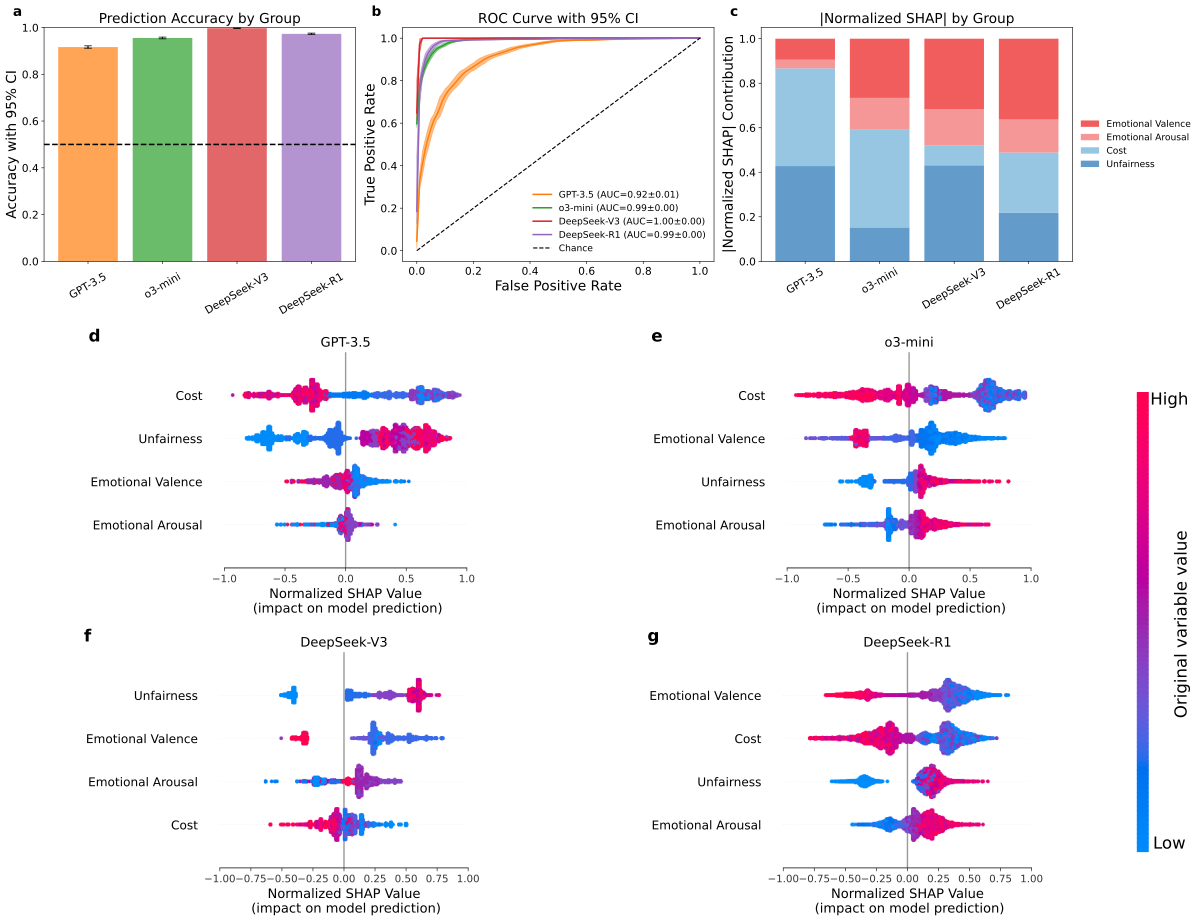

In [19]:
from lxml import etree
from IPython.display import SVG, display

upper_file = "merged_performance.svg"
lower_file = "merged_shap_dot.svg"
out_file = "merged_combined.svg"

fig_width_px = 1200  
NSMAP = {None: "http://www.w3.org/2000/svg"}
svg_root = etree.Element("svg", nsmap=NSMAP)
svg_root.set("width", f"{fig_width_px}px")
svg_root.set("version", "1.1")

bg = etree.Element("rect", x="0", y="0", width=str(fig_width_px), height="10000", fill="white")
svg_root.append(bg)


# performance in the top
tree_upper = etree.parse(upper_file)
upper_svg = tree_upper.getroot()
orig_w = float(upper_svg.get("width").replace("pt","").replace("px",""))
orig_h = float(upper_svg.get("height").replace("pt","").replace("px",""))
scale_upper = fig_width_px / orig_w
upper_h_scaled = orig_h * scale_upper

g_upper = etree.Element("g")
g_upper.set("transform", f"translate(0,0) scale({scale_upper})")
for child in upper_svg:
    g_upper.append(child)
svg_root.append(g_upper)

# SHAP in the bottom
tree_lower = etree.parse(lower_file)
lower_svg = tree_lower.getroot()
orig_w = float(lower_svg.get("width").replace("pt","").replace("px",""))
orig_h = float(lower_svg.get("height").replace("pt","").replace("px",""))
scale_lower = fig_width_px / orig_w
lower_h_scaled = orig_h * scale_lower

g_lower = etree.Element("g")
g_lower.set("transform", f"translate(0,{upper_h_scaled}) scale({scale_lower})")
for child in lower_svg:
    g_lower.append(child)
svg_root.append(g_lower)


svg_root.set("height", f"{upper_h_scaled + lower_h_scaled}px")
tree_out = etree.ElementTree(svg_root)
tree_out.write(out_file, encoding="utf-8", xml_declaration=True)

display(SVG(filename=out_file))